In [1]:
import json
import torch
import pickle
import numpy as np
import scipy.io as sio
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from gensim.corpora import Dictionary

In [2]:
dct = Dictionary.load('./vard.dct')
pToWord = dct
wordToP = dct.token2id
    
with open('./vard_ppmiIDToEmbID.p', 'rb') as fp:
    pToE = pickle.load(fp)

with open('./vard_embIDToPPMIID.p', 'rb') as fp:
    eToP = pickle.load(fp)

In [19]:
sliceCounts = [68, 96, 140, 459, 711, 1089, 1642, 1974, 5194, 4992, 6986, 3034, 725, 815, 1225, 2005, 1669, 2]
times = list(range(len(sliceCounts)))

In [20]:
def eToWord(e):
    if eToP.get(e) is not None:
        return pToWord[eToP.get(e)]
    else: return None
    
def wordToE(word):
    if wordToP.get(word) is not None:
        return pToE[wordToP.get(word)]
    else: return None

pIDs = list(eToP.values())
wordlist = list(map(lambda p: pToWord[p], pIDs))
nw = len(wordlist)

U = torch.load('./vard_results/L10T50G100A1ngU_iter12.t')
V = torch.load('./vard_results/L10T50G100A1ngV_iter12.t')

In [21]:
print(wordToE(eToWord(7))) # BUG

7


In [22]:
U = U[:-1, :, :] # the last time slice only has two documents.
times = times[:-1]

Each word should appear at least x times in each time slice

In [23]:
def plotWordTSNE(word):
    if wordToE(word) is None:
        return "{} not embedded".format(word)
    
    D = 100

    nn = 5
    nc = 5
    emb = U[-1,:,:]             
    X = torch.zeros(U.shape[0],nn,D)
    list_of_words = []
    isword = []
    v = emb[wordToE(word),:] # the embedding of the word at the last time
    
    for year in times:
    
        # calculating the distance from all of the words in the vocab
        emb = U[year,:,:]
        embnrm = torch.norm(emb, dim=0)
        emb_n = emb / embnrm
        v = emb_n[wordToE(word), :]
        d = torch.matmul(emb_n, v) # distance from all words

        # get the closest nn
        idx = torch.argsort(d).numpy()[::-1]
        newwords = [(wordlist[k], year) for k in list(idx[:nn])]
        list_of_words.extend(newwords)

        for k in range(nn):
            isword.append(k==0)

        topN = idx[:nn].tolist()
        X[year,:,:] += emb[topN,:]

    vecs = X.view(-1, 100).numpy()

    pca = PCA()
    pcaWordVecs = pca.fit_transform(vecs)

    Z = TSNE(n_components=2, metric = 'euclidean').fit_transform(pcaWordVecs)
    plt.clf()
    plt.figure(figsize=(20,20))
    traj = []
    print(len(isword))
    for k in range(len(list_of_words)):

        if isword[k]:
            marker = 'ro'
            traj.append(Z[k,:])
        else: marker = 'b.'

        plt.plot(Z[k,0], Z[k,1],marker)
        plt.text(Z[k,0], Z[k,1],list_of_words[k])

    traj = np.vstack(traj)
    plt.plot(traj[:,0],traj[:,1])
    plt.show()

85


<Figure size 432x288 with 0 Axes>

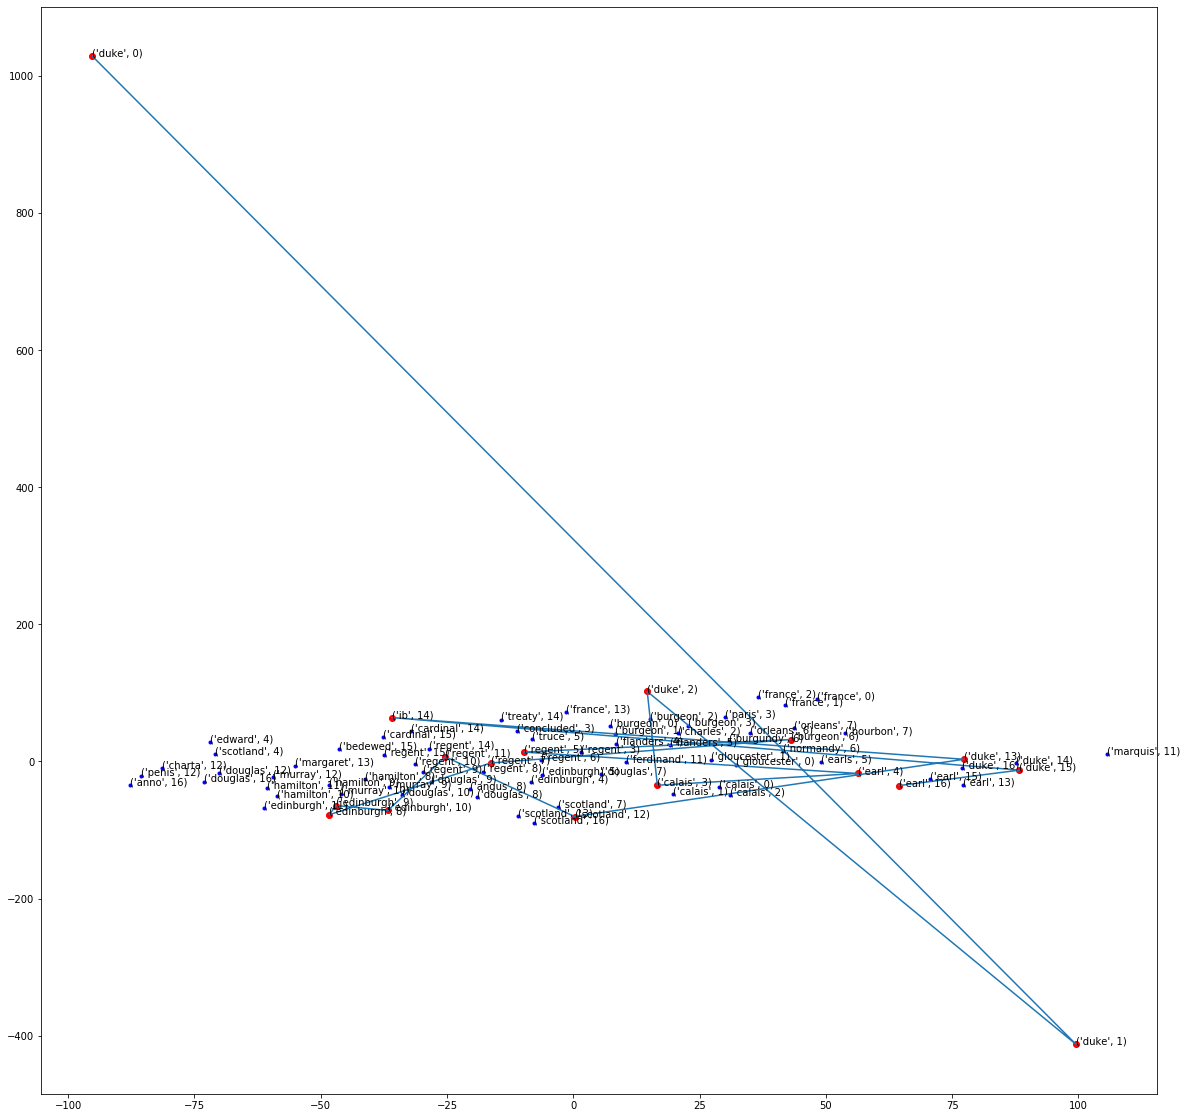

In [24]:
plotWordTSNE('regent')

In [25]:
import pandas as pd

In [26]:
def plotWordTimeline(word, c = 5):
    if wordToE(word) is None:
        return "{} not embedded".format(word)
    
    D = 100

    nn = c
    emb = U[-1,:,:]             
    X = torch.zeros(U.shape[0],nn,D)
    list_of_words = []
    isword = []
    v = emb[wordToE(word),:] # the embedding of the word at the last time
    
    for year in times:
    
        # calculating the distance from all of the words in the vocab
        emb = U[year,:,:]
        embnrm = torch.norm(emb, dim=0)
        emb_n = emb / embnrm
        v = emb_n[wordToE(word)]
        d = torch.matmul(emb_n, v) # distance from all words

        # get the closest nn
        idx = torch.argsort(d).numpy()[::-1]
        newwords = [(wordlist[k], year) for k in list(idx[:nn])]
        list_of_words.extend(newwords)

        for k in range(nn):
            isword.append(k==0)

        topN = idx[:nn].tolist()
        X[year,:,:] += emb[topN,:]
        
    d = dict(zip(list(range(len(times))), [[] for i in range(len(times))]))
    
    for p in list_of_words:
        d[p[1]].append(p[0])
    df = pd.DataFrame(d)
    df.columns = list(range(1473, 1800, 20))
    return df

In [51]:
# cool words: mass, bodies, planet, pound/money, colony, happy, trade
# unchanging words: sail, parliament
plotWordTimeline('mass', 10)
# hypothesis: coherence correlates with usage

,1473,1493,1513,1533,1553,1573,1593,1613,1633,1653,1673,1693,1713,1733,1753,1773,1793
0,mass,mass,mass,mass,mass,mass,mass,mass,mass,mass,mass,mass,mass,particles,mass,mass,mass
1,priest,priest,feast,feast,sacrifice,sacrifice,sacrament,sacrament,altars,sulphur,sulphur,particles,particles,mass,particles,particles,bishop
2,feast,feast,priest,sacrifice,sacrament,sacrament,sacrifice,consecrated,altar,altar,particles,sulphur,fluid,fluid,substance,fluid,sacrament
3,pope,pope,pope,sacrament,bread,priest,consecrated,sacrifice,images,consecrated,liquor,acid,salts,substance,fluid,substances,shells
4,song,sunday,bishops,bread,priest,altar,bread,altar,sacrament,sacrament,acid,salt,animal,bodies,bodies,substance,altar
5,prayers,prayers,sacrament,supper,prayer,prayers,altar,sacraments,consecrated,aggregate,volatile,volatile,substances,salts,gold,bodies,fossil
6,iiij,sacrament,ordained,priest,priests,priests,supper,priest,ceremonies,images,salt,fluid,knights,animal,substances,shells,substance
7,iij,prayer,westminster,ceremonies,communion,consecrated,priest,aggregate,popes,ceremonies,images,dissolved,acid,substances,altar,masses,priest
8,ij,singe,song,prayer,supper,bread,sacraments,ceremonies,romish,masses,sulphurous,liquor,oil,fluids,priest,surface,bread
9,woes,bishop,buried,sunday,cross,prayer,sacrifices,bread,superstitious,liquor,altar,pores,substance,air,acid,vegetable,stone


In [28]:
plotWordTimeline('trade', 10)

,1473,1493,1513,1533,1553,1573,1593,1613,1633,1653,1673,1693,1713,1733,1753,1773,1793
0,sacrifice,sacrifice,sacrifice,trade,trade,trade,merchants,trade,trade,trade,trade,trade,trade,trade,trade,trade,trade
1,wolf,cut,knife,merchants,merchants,merchandise,trade,merchants,merchants,merchants,merchants,merchants,goods,commodities,commerce,commerce,commerce
2,fox,roman,shed,merchandise,merchandise,merchants,merchandise,commodities,commodities,commodities,commodities,commodities,manufactures,goods,goods,goods,goods
3,sheep,romans,pilot,christian,gain,wares,wares,wares,traffic,merchandise,manufactures,manufactures,commerce,merchants,manufactures,manufactures,manufactures
4,roman,emperor,merchandise,precepts,honest,traffic,traffic,merchandise,merchandise,traffic,manufacture,exported,money,manufactures,colonies,merchants,ports
5,gather,sheep,merchants,godliness,sold,merchant,commodities,traffic,merchant,merchant,exported,goods,merchants,commerce,commodities,exported,merchants
6,fable,iron,knighthood,philosophy,wares,commodities,merchant,merchant,sold,trading,trading,money,france,market,merchants,foreign,britain
7,offer,knife,obtained,phrases,price,sold,sell,sold,wares,wares,merchant,commerce,price,foreign,britain,colonies,exported
8,oxen,wolf,stock,christians,merchant,portugal,sold,sell,commodity,sell,trades,foreign,french,colonies,exported,commodities,foreign
9,lyon,cruel,emperors,profession,exercise,buy,buy,ships,trading,commerce,commodity,ships,manufacture,ships,foreign,market,articles


We get different words in the red dots because sometimes the word doesn't appear in the time slice, so we return the closest word to it.

## Axis based Similarity Projection

In [29]:
def closestWords(word, top_n = 10):
    if wordToE(word) is None:
        return "{} not embedded".format(word)
    
    D = 100

    nn = top_n
    nc = top_n
    emb = U[-1,:,:]             
    X = torch.zeros(U.shape[0],nn,D)
    list_of_words = []
    isword = []
    v = emb[wordToE(word),:] # the embedding of the word at the last time
    
    for year in times:
    
        # calculating the distance from all of the words in the vocab
        emb = U[year,:,:]
        embnrm = torch.norm(emb, dim=0)
        emb_n = emb / embnrm
        v = emb_n[wordToE(word),:]
        d = torch.matmul(emb_n, v) # distance from all words

        # get the closest nn
        idx = torch.argsort(d).numpy()[::-1]
        newwords = [(wordlist[k], year, d[k].numpy().tolist()) for k in list(idx[:nn])]
        list_of_words.extend(newwords)

        for k in range(nn):
            isword.append(k==0)

        topN = idx[:nn].tolist()
        X[year,:,:] += emb[topN,:]

    vecs = X.view(-1, 100).numpy()
    return list_of_words
    

In [30]:
# v = 100 x 1
def cosineSim(t, word1, word2):
    if wordToE(word1) is None:
        return "{} not embedded".format(word1)
    if wordToE(word2) is None:
        return "{} not embedded".format(word2)
    
    v1 = U[t, wordToE(word1), :]
    v2 = U[t, wordToE(word2), :]
    theta = torch.matmul(v1, v2) / (torch.norm(v1) * torch.norm(v2))
    return theta.numpy().tolist()

In [31]:
for i in range(U.shape[0]):
    print(cosineSim(i, 'france', 'america'))

0.25555357336997986
0.28914088010787964
0.1964876502752304
0.2519978880882263
0.2922884523868561
0.20502153038978577
0.17971965670585632
0.1622290164232254
0.16988830268383026
0.26205211877822876
0.2106500267982483
0.2527059018611908
0.4350855052471161
0.5235496163368225
0.5171530842781067
0.5761014223098755
0.7145865559577942


In [32]:
def projectAxes(t, word1, word2, wordList):
    if wordToE(word1) is None:
        return "{} not embedded".format(word1)
    if wordToE(word2) is None:
        return "{} not embedded".format(word2)
    for word in wordList:
        if wordToE(word) is None:
            return "{} not embedded".format(word)
    
    plt.clf()
    plt.figure(figsize=(10,10))
    plt.xlabel(word1)
    plt.ylabel(word2)
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    wordCoords = []
    
    for word in wordList:
        t1 = cosineSim(t, word, word1)
        t2 = cosineSim(t, word, word2)
        wordCoords.append((word, t1, t2))
        
    for p in wordCoords:
        plt.plot(p[1], p[2], 'r.')
        plt.text(p[1], p[2], p[0])

    plt.show()
    return wordCoords

In [33]:
def projectSpectrum(t, word1, word2, wordList, show=True):
    if wordToE(word1) is None:
        return "{} not embedded".format(word1)
    if wordToE(word2) is None:
        return "{} not embedded".format(word2)
    for word in wordList:
        if wordToE(word) is None:
            return "{} not embedded".format(word)
    
    v1 = U[t, wordToE(word1), :]
    v2 = U[t, wordToE(word2), :]
    diff = v1 - v2
    
    wordVals = []
    for word in wordList:
        v = U[t, wordToE(word), :]
        theta = torch.matmul(diff, v) / (torch.norm(diff) * torch.norm(v))
        wordVals.append((word, theta.numpy().tolist()))
    
    if show:
        plt.clf()
        plt.figure(figsize=(10,10))
        plt.ylabel("<---{}------{}--->".format(word2, word1))
    
        for p in wordVals:
            plt.plot(.5, p[1], 'r.')
            plt.text(.5, p[1], p[0])
        
        plt.show()
    return wordVals

In [34]:
def spectrumTime(word1, word2, wordList, start=1473, end=1793):
    
    if wordToE(word1) is None:
        return "{} not embedded".format(word1)
    if wordToE(word2) is None:
        return "{} not embedded".format(word2)
    for word in wordList:
        if wordToE(word) is None:
            return "{} not embedded".format(word)
    
    plt.clf()
    plt.figure(figsize=(18,7))
    plt.ylabel("<---{}------{}--->".format(word2, word1))
    plt.xlabel("time")
    plt.xlim((start - 10, end + 10))
    
    times = list(range(start, end, int( (end - start) / U.shape[0] )))
    trajs = dict(zip(wordList, [[] for w in wordList]))
    
    for time in range(U.shape[0]):
        ps = projectSpectrum(time, word1, word2, wordList, show=False)
        for p in ps:
            plt.plot(times[time], p[1], 'r.')
            if time == (len(times) - 1) or time == int(time/2) or time == 0:
                plt.text(times[time], p[1], p[0])
            trajs[p[0]].append((times[time], p[1]))
    
    for traj in trajs.values():
        traj = np.vstack(traj)
        plt.plot(traj[:,0],traj[:,1])
    
    plt.show()

<Figure size 432x288 with 0 Axes>

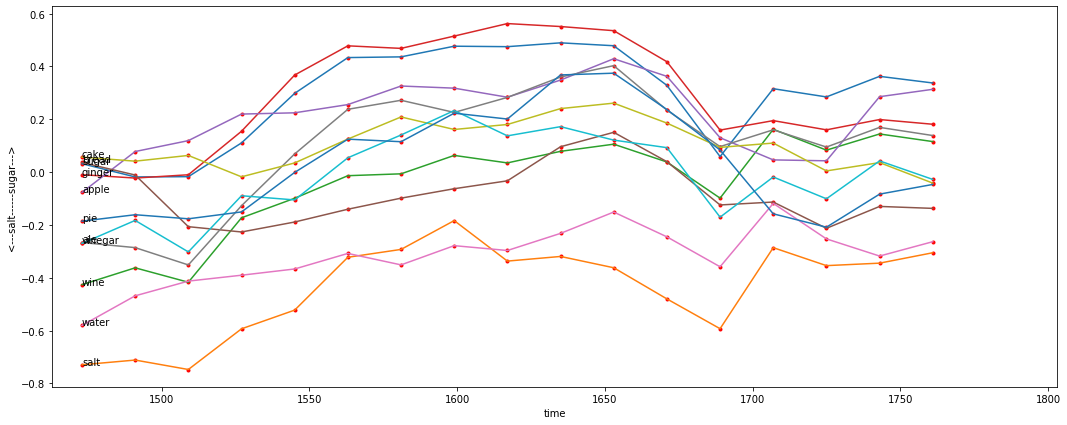

In [35]:
spectrumTime('sugar', 'salt', ['sugar', 
                               'salt', 
                               'wine', 
                               'ginger',
                               'apple',
                               'bread',
                               'water',
                               'ale',
                               'cake',
                               'vinegar',
                               'pie'])

<Figure size 432x288 with 0 Axes>

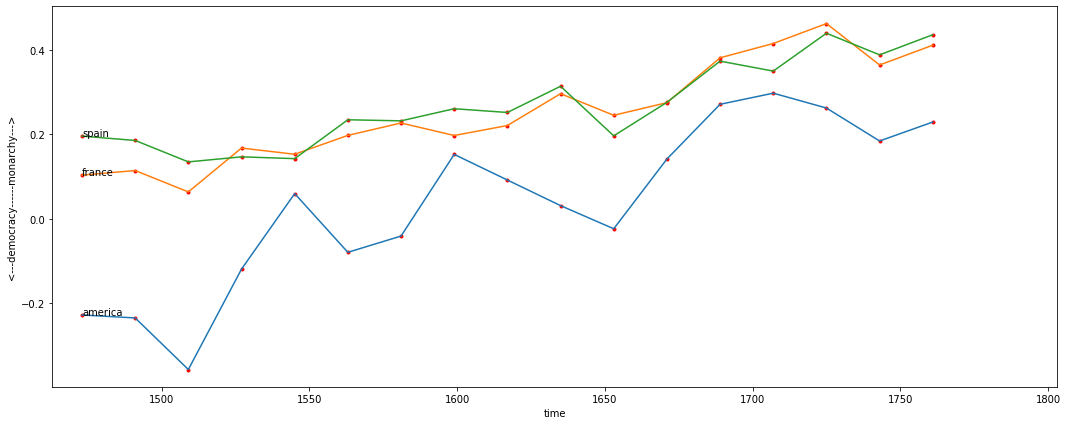

In [36]:
spectrumTime('monarchy', 'democracy', [
    'america',
#     'england',
    'france',
    'spain',
])

In [37]:
spectrumTime('war', 'peace', [
    'america',
    'england',
    'france',
    'spain',
    'scotland',
    'netherlands'
])

'peace not embedded'

The Anglo-Spanish War (1585–1604) was an intermittent conflict between the kingdoms of Spain and England that was never formally declared. The war became deadlocked around the turn of the 17th century during campaigns in the Netherlands, France and Ireland.

In [38]:
def cosSimTime(word1, wordList, start = 1473, end = 1793, periods = 17): 
    
    if wordToE(word1) is None:
        return "{} not embedded".format(word1)
    for word in wordList:
        if wordToE(word) is None:
            return "{} not embedded".format(word)

    plt.clf()
    plt.figure(figsize=(18,7))
    plt.ylabel(word1)
    plt.xlabel("time")
    plt.xlim((start - 10, end + 10))
    
    trajs = dict(zip(wordList, [[] for w in wordList]))
    times = list(range(start,end,int((end - start)/periods)))
    
    for time in range(periods):
        ps = []
        for word in wordList:
            ps.append((word, cosineSim(time, word1, word)))
            
        for p in ps:
            trajs[p[0]].append((times[time], p[1]))
            plt.plot(times[time], p[1], 'r.')
            if(time == 0 or time == 17):
                plt.text(times[time], p[1], p[0])
            
    for traj in trajs.values():
        traj = np.vstack(traj)
        plt.plot(traj[:,0], traj[:,1])
        
    plt.show()

<Figure size 432x288 with 0 Axes>

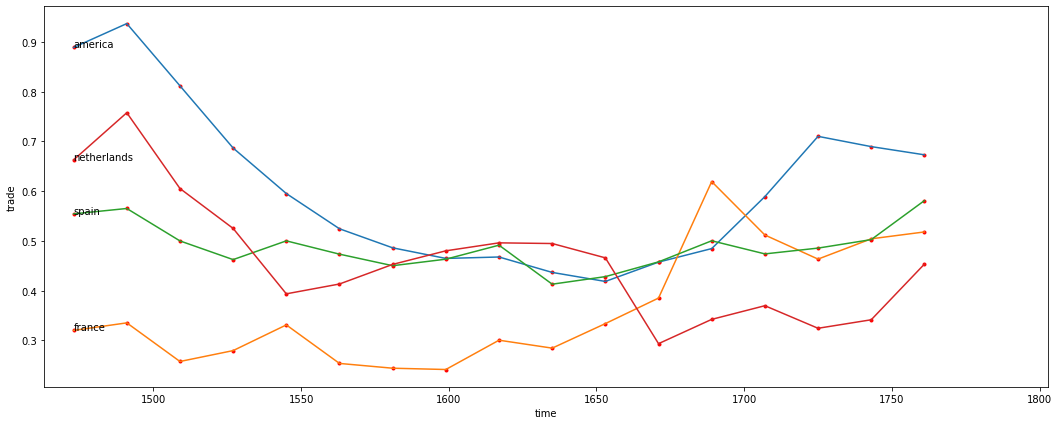

In [39]:
cosSimTime('trade', [
    'america',
#     'england',
    'france',
    'spain',
    'netherlands'])

In [40]:
cosSimTime('trade', [
    'sugar',
    'nutmeg',
    'ginger',
    'salt',
    'tea',
])

'nutmeg not embedded'

In [41]:
cosSimTime('colony', [
    'america',
    'india',
#     'brazil',
    'ireland',
    'guiana',
    'jamaica'
])

'guiana not embedded'

In [42]:
cosSimTime('king', [
    'charles',
    'henry',
    'edward',
    'richard',
    'jane',
    'mary',
    'philip',
    'elizabeth',
    'james',
    'william',
])

'king not embedded'

In [43]:
cosSimTime('medicine', [
    'humour',
    'blood',
    'phlegm',
    'bile'
])

'blood not embedded'

In [44]:
cosSimTime('power', [
    'king',
    'queen',
    'parliament'
])

'power not embedded'

## Word Norm

In [48]:
def norm(words):
    allnorms = []

    for w in words:
        print(U[:,wordToE(w),:].shape)
        norms = torch.norm(U[:,wordToE(w),:], dim=1)
        print(norms.shape)
        norms = norms / torch.sum(norms)
        allnorms.append(norms.numpy())

    years = list(range(1473,1820,20))[:-1]
    markers = ['+','o','x','*']
    plt.clf()
    for k in range(len(allnorms)):
        norms = allnorms[k]
        plt.plot(years,norms,marker=markers[k],markersize=7)
    plt.legend(words)
    plt.xlabel('year')
    plt.ylabel('word norm')
    plt.show()

torch.Size([17, 100])
torch.Size([17])
torch.Size([17, 100])
torch.Size([17])
torch.Size([17, 100])
torch.Size([17])
torch.Size([17, 100])
torch.Size([17])


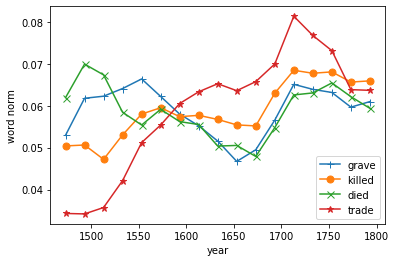

In [49]:
norm(['grave', 'killed', 'died', 'trade'])

torch.Size([17, 100])
torch.Size([17])
torch.Size([17, 100])
torch.Size([17])


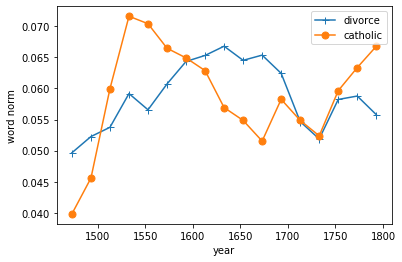

In [50]:
norm(['divorce', 'catholic'])

In [ ]:
norm(['parliament'])